# Импортируем библиотеки

In [1]:
import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#mean_absolute_percentage_error нет в sklearn v0.22, поэтому напишем сами:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / (y_true)))

from sklearn.metrics import mean_squared_error , max_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor

import xgboost as xgb
import optuna
import lightgbm as lgbm

np.random.seed(42)

# Предобработка данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.shape

(377185, 18)

Количество пропущенных значенний:

In [5]:
df.isna().sum() / (df.shape[0])*100 #процент пропусков

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.661956
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.957846
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Удаляем строки без целевой переменной:

In [6]:
df = df.loc[df['target'].isna() == False]

In [7]:
df.shape

(374704, 18)

Очищаем целевую переменную:

In [8]:
def target_format(target):
    target = re.sub('[^0-9]', '', target) #оставляем только цифры
    target = int(target)
    return target

In [9]:
df['target'] = df['target'].apply(target_format)
df['target'].describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

Очищаем признаки:

In [10]:
# Преобразовываем в действительные числа
def features_float_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('1 1/2', '1.5', str(feature)) # заменяем 1 1/2 на 1.5 (признак stories)
    feature = re.sub('[^0-9,\.]', '', feature) # оставляем только цифры
    feature = re.sub(',', '.', feature) # заменяем ',' на '.'
    
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем площадь
def sqft_format(feature):
    if feature == 0:
        return feature
    feature = re.sub('[^0-9\.]', '', feature) # оставляем только цифры
   
    try:
        feature = float(feature)
    #если feature - пустая строка, возвращаем 0
    except:
        feature = 0
    return feature
# Преобразовываем статус
def status_format(status):
    status = status.lower()
    # если дом ещё не сделан,оставляем только 'coming soon', дату удаляем
    if status.startswith('coming soon'): 
        status = 'coming soon'
        
    status = re.sub('[^a-z]', ' ', status) # оставляем только буквы
    status = re.sub(r'\b\w{,2}\b', '', status) # удаляем сочетание из 1 и 2 букв
    status = re.sub(r'\s+', '', status) # заменяем 1 или более пробелов на ''
    if status == 'active' or status == 'for sale': # бóльшая часть домов - for sale или active
        status = 1
    else:
        status = 0
    return status
#Преобразовываем фичу камина
def fireplace_format(fireplace):
    if fireplace == 0:
        return fireplace
    fireplace = fireplace.lower()
    
    if fireplace.count('no')>0:
        fireplace = 0
    else:
        fireplace = 1
    return fireplace

In [11]:
dummy_features = ['status','state']  
drop_features = ['street', 'mls-id', 'MlsId', 'schools', 'homeFacts', 'city', 'zipcode'] 

#### Status

In [12]:
df.status.value_counts()

for sale                   156100
Active                     105206
For sale                    43465
foreclosure                  5677
New construction             5459
                            ...  
Contingent   No Show            1
Temporary Active                1
Backup                          1
Coming soon: Oct 29.            1
Pending W/Backup Wanted         1
Name: status, Length: 156, dtype: int64

Приблизительно 80% домов - ```Active``` или ```for sale```, поэтому вместо них ставим ```1```, иначе ```0```
(заполняем пропуски на пустые строки, и применяем ```status_format```):

In [13]:
df['status'] = df['status'].fillna('')
df['status'] = df['status'].apply(status_format)

#### Property Type

In [14]:
df.propertyType.value_counts()

single-family home                                                                                91376
Single Family                                                                                     61888
Single Family Home                                                                                31725
condo                                                                                             25878
lot/land                                                                                          20532
                                                                                                  ...  
Georgian, Multi Generational                                                                          1
Mobile Home                                                                                           1
Designated Historical Home, Single Detached, English, French, Other (See Remarks), Traditional        1
Contemporary/Modern, Ranch, Spanish                             

Приблизительно 50% домов - ```single family```, поэтому оставляем только этот признак:

In [15]:
def propertyType_format(propertyType):
    propertyType = propertyType.lower()
    propertyType = re.sub('[^a-z]', ' ', propertyType)# оставляем только буквы
    
    # если начинается на 'single family' - ставим 1, иначе 0
    if propertyType.startswith('single family'): 
        propertyType = 1 
    else:
        propertyType = 0
    return propertyType

In [16]:
df['propertyType'] = df['propertyType'].fillna('')
df['propertyType'] = df['propertyType'].apply(propertyType_format)

#### Private pool
Вместо пропусков ставим ```no```, заполняем вместо ```yes``` - 1, вместо ```no``` - 0

In [17]:
df['private pool'] = df['private pool'].fillna('no')
df['private pool'] = df['private pool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['PrivatePool'].fillna('no')
df['PrivatePool'] = df['PrivatePool'].apply(lambda pool: 1 if pool.lower() == 'yes' else 0)

df['PrivatePool'] = df['private pool'] | df['PrivatePool']
df.drop(['private pool'], axis = 1, inplace = True)

#### Baths, sqft, beds, stories, fireplace
Заполняем пропуски нулями (кроме этажей - их заменяем на ```1```).
К ```Baths, beds, stories``` применяем ```features_float_format```, к ```sqft - sqft_format```, а к ```fireplace``` - ```fireplace_format```:

In [18]:
df['baths'] = df['baths'].fillna(0)
df['baths'] = df['baths'].apply(features_float_format)

df['sqft'] = df['sqft'].fillna(0)
df['sqft'] = df['sqft'].apply(sqft_format)

df['beds'] = df['beds'].fillna(0)
df['beds'] = df['beds'].apply(features_float_format)

df['stories'] = df['stories'].fillna(1)
df['stories'] = df['stories'].apply(features_float_format)

df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(fireplace_format)

#### Year Built

In [19]:
df['homeFacts'] = df['homeFacts'].apply(eval) # конвертируем строку в словарь, используя eval

Нужное нам значение хранится в первом словаре, который хранится в списке, который, в свою очередь, хранится в словаре с ключом ```atAGlanceFacts```:

In [20]:
M = df['homeFacts'][0]
print(M,'\n')
print(M['atAGlanceFacts'],'\n')
print(M['atAGlanceFacts'][0],'\n')
print(M['atAGlanceFacts'][0]['factValue'])

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]} 

[{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}] 

{'factValue': '2019', 'factLabel': 'Year built'} 

2019


In [21]:
def yearBuilt_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём первый елемент списка
    yearBuilt = homeFacts[0]
    # если словарь не пуст, то берем значение
    if yearBuilt.get('factLabel') == 'Year built':
        yearBuilt = yearBuilt.get('factValue')
    # берём первый второй списка
    yearRemodeled = homeFacts[1]
    # если словарь не пуст, то берем значение
    if yearRemodeled.get('factLabel') == 'Remodeled year':
        yearRemodeled = yearRemodeled.get('factValue')
    
    # если yearRemodeled - число, выводим его, иначе - yearBuilt
    try:
        yearRemodeled = int(yearRemodeled)
        return yearRemodeled
    except:
        yearRemodeled = 0
    # если homeFacts - число, то выводим его, иначе 0
    try:
        yearBuilt = int(yearBuilt)
    except:
        yearBuilt = 0
    return yearBuilt

In [22]:
df['yearBuilt'] = df['homeFacts'].apply(yearBuilt_format)

#### Heating

In [23]:
def heating_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём третий елемент списка
    homeFacts = homeFacts[2]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Heating':
        homeFacts = homeFacts.get('factValue')
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что в доме нет отопления
        return 0
    else:
        return 1

In [24]:
df['heating'] = df['homeFacts'].apply(heating_format)

#### Parking

In [25]:
def parking_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём пятый елемент списка
    homeFacts = homeFacts[4]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'Parking':
        homeFacts = homeFacts.get('factValue')
        homeFacts = str(homeFacts).lower()
        
    if homeFacts in ['','none','no data']: # если homeFacts '','none' или 'no data' - считаем, что участке нет парковки
        homeFacts = 0
    else:
        homeFacts = re.sub('[^0-9]', '', homeFacts) # оставляем только цифры
        try:
            homeFacts = int(homeFacts)
            
        # Если homeFacts - строка ('Attached Garage'), считаем, что в доме 1 парковка
        except:
            homeFacts = 1
    return homeFacts

In [26]:
df['parking'] = df['homeFacts'].apply(parking_format)

#### Lot size

In [27]:
def lotsize_format(homeFacts):
    # если homeFacts - непустой словарь, берём значение 'atAGlanceFacts', иначе 0
    homeFacts = homeFacts.get('atAGlanceFacts', 0) 
    if homeFacts == 0: 
        return 0
    # берём шестой елемент списка
    homeFacts = homeFacts[5]
    # если словарь не пуст, то берем значение
    if homeFacts.get('factLabel') == 'lotsize':
        homeFacts = str(homeFacts.get('factValue'))
        
    if homeFacts == 0:
        return homeFacts
    homeFacts = homeFacts.replace('Sq. Ft.','')
    homeFacts = re.sub('[^0-9\.]', '', homeFacts) # оставляем только цифры
   
    try:
        homeFacts = float(homeFacts)
    #если homeFacts - пустая строка, возвращаем 0
    except:
        homeFacts = 0
    if homeFacts < 10: # если homeFacts подано в акрах
        homeFacts *= 43560
    return homeFacts

Если lotsize равно 0, то записываем в lotsize значенние в sqft:

In [28]:
df['lotsize'] = df.apply(lambda x: x['sqft'] if lotsize_format(x['homeFacts']) == 0 
                         else lotsize_format(x['homeFacts']), 
                         axis = 1)

#### Schools rating

In [29]:
df['schools'] = df['schools'].apply(eval) # конвертируем строку в словарь, используя eval

Список с рейтингами школ хранится в словаре, который хранится в списке:

In [30]:
M = df['schools'][0]
print(M,'\n')
print(M[0],'\n')
print(M[0]['rating'])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}] 

{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']} 

['4', '4', '

In [31]:
def rating_format(schools):
    # если schools - непустой словарь, берём значение 'rating', иначе 0
    schools = schools[0]
    schools = schools.get('rating', 0)
    if schools == 0: 
        return 0
    
    rating = []
    for x in schools:
        x = re.sub('/10','',x) # если рейтинг записан в формате 'x/10', заменяем на 'x'
        rating.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое рейтингов
    return np.mean(rating)

Применяем ```rating_format```, если результат - ```nan```, заменяем на ```0```:

In [32]:
df['rating'] = df['schools'].apply(rating_format)
df['rating'] = df['rating'].fillna(0)

C:\Users\andru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.



#### Distance
По аналогии с ```rating```, выбираем значение из списка словарей и ищем среднее арифметическое расстояний

In [33]:
def distance_format(schools):
    # если schools - непустой словарь, берём значение 'data', иначе 0
    schools = schools[0]
    schools = schools.get('data', 0)
    if schools == 0: 
        return 0
    # если schools - непустой словарь, берём значение 'distance', иначе 0
    schools = schools.get('Distance', 0)
    if schools == 0: 
        return 0
    
    distance=[]
    for x in schools:
        distance.append(features_float_format(x)) # с помощью features_float_format превращаем x в число
    # ищем среднее арифметическое расстояний
    return np.mean(distance)

Применяем ```distance_format``` и заполняем пропуски нулями:

In [34]:
df['distance'] = df['schools'].apply(distance_format)
df['distance'] = df['distance'].fillna(0)

Удаляем ненужные фичи:

In [35]:
df.drop(drop_features, axis = 1, inplace = True)

#### State 
Штаты - dummy-features, поэтому применяем к ```df['state']``` функцию ```pd.get_dummies``` ,и конкатенируем результат к датасету:

In [36]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis = 1)
df.drop('state', axis = 1, inplace = True)

##### Итог:
Мы предобработали и очистили данные, и получили 8 числовых и 43 dummy признака.

# Статистический анализ

In [37]:
df.head()

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
0,1,1,3.5,1,2900.0,4.0,1.0,0,418000,2019,...,0,0,0,0,0,0,0,0,0,0
1,0,1,3.0,0,1947.0,3.0,2.0,0,310000,2019,...,0,0,0,0,0,0,0,0,1,0
2,0,1,2.0,1,3000.0,3.0,1.0,1,2895000,1967,...,0,0,0,0,0,0,0,0,0,0
3,0,1,8.0,1,6457.0,5.0,3.0,0,2395000,2006,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0.0,0,0.0,0.0,1.0,0,5000,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
df.describe(include = 'all')

,status,propertyType,baths,fireplace,sqft,beds,stories,PrivatePool,target,yearBuilt,...,OT,PA,SC,TN,TX,UT,VA,VT,WA,WI
count,374704.000000,374704.000000,3.747040e+05,374704.000000,3.747040e+05,374704.000000,374704.000000,374704.000000,3.747040e+05,3.747040e+05,...,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000,374704.000000
mean,0.281953,0.493694,3.718902e+02,0.267360,5.921395e+03,2.417060,1.500874,0.118152,6.447575e+05,2.990631e+06,...,0.000003,0.014705,0.000075,0.048654,0.222464,0.003525,0.002135,0.002306,0.036666,0.001206
std,0.449951,0.499961,1.928389e+05,0.442583,1.499304e+06,3.936648,3.338053,0.322788,1.841431e+06,1.293752e+09,...,0.001634,0.120369,0.008644,0.215145,0.415901,0.059271,0.046157,0.047964,0.187941,0.034711
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000e+00,0.000000,1.035000e+03,0.000000,1.000000,0.000000,1.869900e+05,1.936000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,2.000000e+00,0.000000,1.656000e+03,3.000000,1.000000,0.000000,3.200000e+05,1.981000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,3.000000e+00,1.000000,2.458000e+03,4.000000,2.000000,0.000000,5.821000e+05,2.006000e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.161161e+08,1.000000,7.959794e+08,871.000000,1120.000000,1.000000,1.950000e+08,5.599906e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Построим матрицу корреляций:

In [39]:
corr = df.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "5pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("correlation matrix")\
    .set_precision(2)\
    .set_table_styles(magnify())

Избыточной кореляции между признаками нету, значит никаких признаков удалять ненужно. 
Построим гистограмы с различными признаками:

Построим гистограмму логарифма целевой переменной:

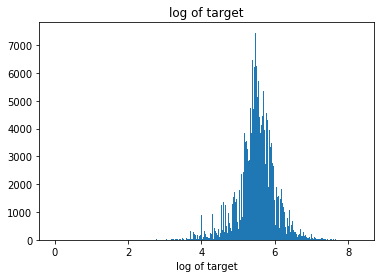

In [40]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Отсюда видно, что существует пик в точке 5.5, а распределение - похоже на нормальное.

Удалим объекты, где стоимость домов меньше ```1000$``` или больше ```100 000 000$```:

In [41]:
df = df.loc[(df['target']> 10000) & (df['target'] < 100000000)]

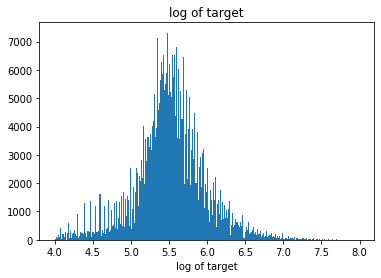

In [42]:
_ = plt.hist(np.log10(df['target']),bins = 'auto')
plt.title('log of target')
plt.xlabel('log of target')
plt.show()

Построим гистограмму логарифма площади, если площадь не равна ```0```:

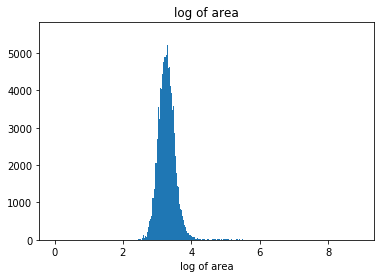

In [43]:
_ = plt.hist(np.log10(df.loc[(df['sqft']>0)]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Удалим объекты, где площадь домов меньше ```1000``` или больше ```100 000``` кв. фт:

In [44]:
df = df.loc[(df['sqft']>100) & (df['sqft'] < 10**5)]

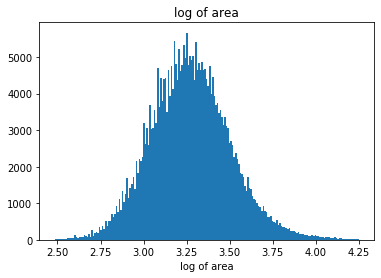

In [45]:
_ = plt.hist(np.log10(df.loc[(df['sqft']>300) & (df['sqft'] < 10**4.25)]['sqft']),bins = 'auto')
plt.title('log of area')
plt.xlabel('log of area')
plt.show()

Видно пик около 3.25. Значит, большинство значенний площади находятся на промежутке от около ```1000``` до ```10000```.

Построим гистограмму распределений кроватей, убрав объекты, где количество кроватей меньше ```15```:

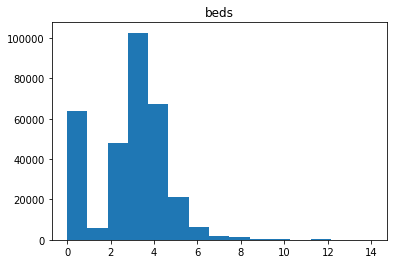

In [46]:
_ = plt.hist(df[df['beds']<15]['beds'],bins = 15)
plt.title('beds')
plt.show()

Распределение похоже на нормальное (не считая значенний = 0).

Построим гистограмму распределений логарифма lot siz'а, убрав объекты, где lotsize равно ```0```:

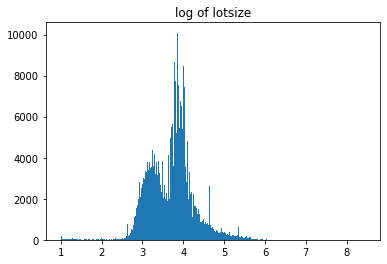

In [47]:
_ = plt.hist(np.log10(df[df['lotsize']>0]['lotsize']),bins = 'auto')
plt.title('log of lotsize')
plt.show()

Заменим значенния этажей больше 70 на 2:

In [48]:
df = df.where(df['stories']<70,2)

Построим гистограмму распределений логарифма этажей, убрав объекты, где количество этажей равно 0:

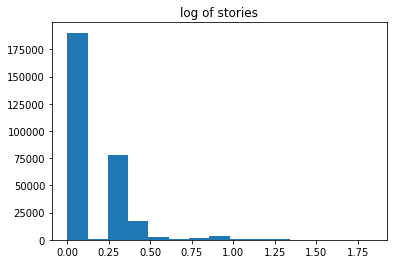

In [49]:
_ = plt.hist(np.log10(df.loc[df['stories'] >= 1]['stories']),bins = 15)
plt.title('log of stories')
plt.show()

Распределение похоже на нормальное(не считая значенний = 0).

Построим гистограмму распределений рейтинга школ:

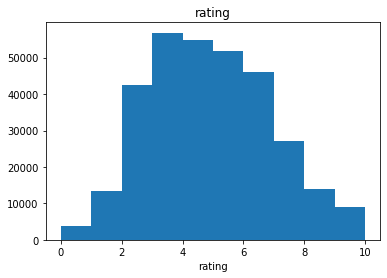

In [50]:
_ = plt.hist(df['rating'],bins = 10)
plt.title('rating')
plt.xlabel('rating')
plt.show()

Построим гистограмму логарифма расстояний:

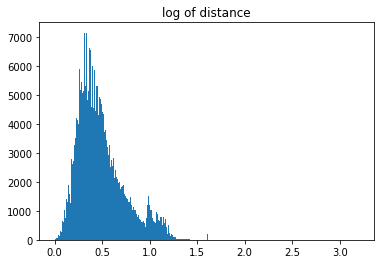

In [51]:
_ = plt.hist(np.log10(df['distance']+1),bins = 'auto')
plt.title('log of distance')
plt.show()

Построим гистограмму распределений ванных, убрав объекты, где количество ванных больше 20 или равно 0:

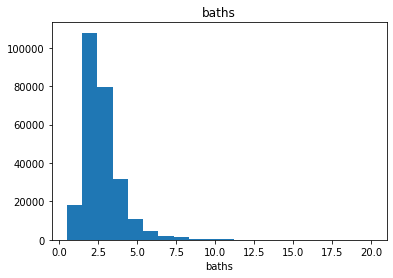

In [52]:
_ = plt.hist(df.loc[(df['baths'] != 0) & (df['baths'] <= 20)]['baths'],bins = 20)
plt.title('baths')
plt.xlabel('baths')
plt.show()

Заменим значенния ```yearBuilt``` больше ```2021``` и меньше ```1900``` на ```2018```:

In [53]:
df = df.where((df['yearBuilt'] < 2021) & (df['yearBuilt'] > 1900),2019)

Построим гистограмму распределений года постройки, убрав значенния меньше 1875:

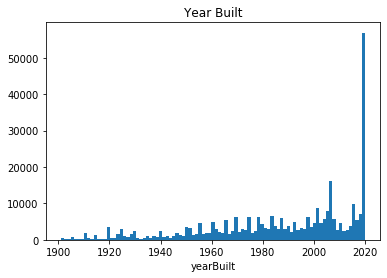

In [54]:
_ = plt.hist(df.loc[df['yearBuilt'] >= 1875]['yearBuilt'],bins = 'auto')
plt.title('Year Built')
plt.xlabel('yearBuilt')
plt.show()

###### Точечные диаграммы целевой переменной и признаков

Построим точечную диаграмму целевой переменной и рейтинга школ:

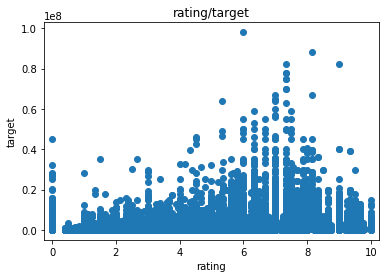

In [55]:
_ = plt.scatter(df['rating'],df['target'])

plt.xlim(-0.25,10.25)

plt.title('rating/target')
plt.xlabel('rating')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и логарифма расстояний до школ:

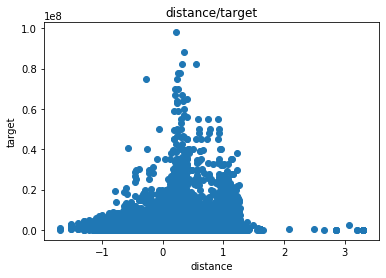

In [56]:
_ = plt.scatter(np.log10(df.loc[df['distance']>0]['distance']),df.loc[df['distance']>0]['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов

plt.title('distance/target')
plt.xlabel('distance')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма количества этажей:

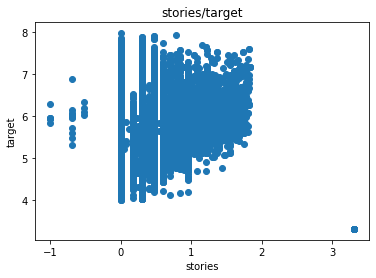

In [57]:
M = df.loc[(df['stories']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['stories']),
                np.log10(M['target']))

plt.title('stories/target')
plt.xlabel('stories')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и количества кроватей:

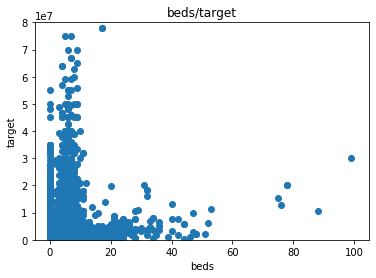

In [58]:
_ = plt.scatter(df['beds'],df['target'])
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(-5,105)
plt.ylim(-10,1e7*8)

plt.title('beds/target')
plt.xlabel('beds')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму целевой переменной и года постройки:

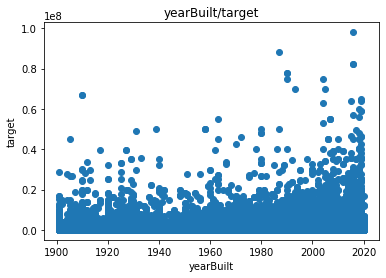

In [59]:
_ = plt.scatter(df['yearBuilt'],df['target'])

plt.title('yearBuilt/target')
plt.xlabel('yearBuilt')
plt.ylabel('target')

plt.show()

Построим точечную диаграмму логарифма целевой переменной и логарифма площади:

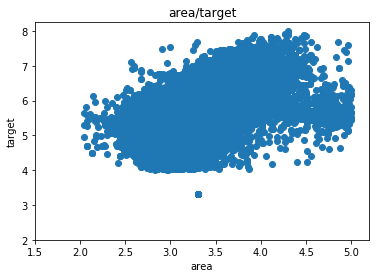

In [60]:
M = df.loc[(df['sqft']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['sqft']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(1.5,5.2)
plt.ylim(2,8.25)

plt.title('area/target')
plt.xlabel('area')
plt.ylabel('target')

plt.show()

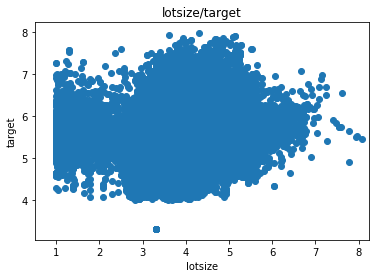

In [61]:
M = df.loc[(df['lotsize']>0) & (df['target']>0)] # фильтруем нулевые значения
_ = plt.scatter(np.log10(M['lotsize']),
                np.log10(M['target']))
# Ограничим график по осям, чтобы рассмотреть данные без шумов
plt.xlim(0.5,8.25)

plt.title('lotsize/target')
plt.xlabel('lotsize')
plt.ylabel('target')

plt.show()

Поскольку распределения логарифма целевой переменной, логарифма количества этажей, логарифма lotsiz'а, логарифма площади и логарифма расстояний до школ - похожы на нормальные, то можна к этим признакам применить логарифм:

In [62]:
df = df.loc[(df['sqft']>0) & (df['distance']>0)] # берём только значения больше 0 (log(0)=-inf)
df['sqft'] = df['sqft'].apply(lambda x: np.log10(x))
df['distance'] = df['distance'].apply(lambda x: np.log10(x))
df['stories'] = df['stories'].apply(lambda x: np.log10(x+1))
df['lotsize'] = df['lotsize'].apply(lambda x: np.log10(x+1))

Для ```target``` воспользуемся ```TransformedTargetRegressor```

Разобьем датафрейм на 2: в одном отдельные домы (```'single home'```), в других - остальные(квартиры, кондоминиумы):

In [63]:
#df = df.loc[df['propertyType']==0]
#df = df.drop('propertyType',axis=1)
df_single = df.loc[df['propertyType'] == 1]  
df_condo = df.loc[df['propertyType'] == 0]
df_single = df_single.drop('propertyType',axis = 1)
df_condo = df_condo.drop('propertyType',axis = 1) 

# Построение моделей

Разобьем данные на обучающаю и тестовую выборки:

In [64]:
X_single, y_single = df_single.drop('target', axis = 1), df_single['target']
X_condo, y_condo = df_condo.drop('target', axis = 1), df_condo['target']

In [65]:
X_train_single, X_test_single, y_train_single, y_test_single = train_test_split(X_single, y_single, 
                                                                                test_size = 0.2, random_state = 42)

X_train_condo, X_test_condo, y_train_condo, y_test_condo = train_test_split(X_condo, y_condo,
                                                                            test_size = 0.2, random_state = 42)

In [66]:
X_train_single.shape, y_train_single.shape, X_test_single.shape, y_test_single.shape

((131440, 52), (131440,), (32860, 52), (32860,))

In [67]:
X_train_condo.shape, y_train_condo.shape, X_test_condo.shape, y_test_condo.shape

((103112, 52), (103112,), (25779, 52), (25779,))

Списки с моделями для финального стекинга:

In [68]:
estimators_single = []
estimators_condo = []

Сделаем функцию для оценки точности предсказаний:

In [69]:
def evaluate(clf, X_train, y_train, X_test, y_test):
    #делаем предсказание
    train_predict = clf.predict(X_train)
    test_predict = clf.predict(X_test)
    #mse
    print('train mse :', mean_squared_error(y_train, train_predict) )
    print('test mse  :', mean_squared_error(y_test, test_predict) )
    #max error
    print('train max error :', max_error(y_train, train_predict) )
    print('test max error  :', max_error(y_test, test_predict) )
    #MAE
    print('train mean absolute error :', mean_absolute_error(y_train, train_predict) )
    print('test mean absolute error  :', mean_absolute_error(y_test, test_predict) )
    #MAPE
    print('train mean absolute percentage error :', mean_absolute_percentage_error(y_train, train_predict) )
    print('test mean absolute percentage error  :', mean_absolute_percentage_error(y_test, test_predict) )
    #RMSE
    print('train rmse :', np.sqrt(mean_squared_error(y_train, train_predict) ))
    print('test rmse  :',np.sqrt(mean_squared_error(y_test, test_predict) ))
    #Coefficient of determination
    print('train R^2', clf.score(X_train,y_train)) 
    print('test R^2', clf.score(X_test,y_test))

### Линейная регрессия

In [70]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 
regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [71]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single) 

train mse : 1.2943315924726646e+32
test mse  : 1002591533176.0815
train max error : 4.1246447666993946e+18
test max error  : 39974414.73251143
train mean absolute error : 31380438225700.75
test mean absolute error  : 256048.16224649086
train mean absolute percentage error : 69889617.27962449
test mean absolute percentage error  : 0.42298004787655896
train rmse : 1.137686948361747e+16
test rmse  : 1001294.9281685599
train R^2 -5.757087332998396e+19
test R^2 0.4976772004098352


In [72]:
lr = LinearRegression()
# Применяем логарифм к целевой переменной
regr = TransformedTargetRegressor(regressor = lr, func=np.log, inverse_func=np.exp) 

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [73]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 2710819496911.024
test mse  : 2480261927018.886
train max error : 87409466.17717582
test max error  : 53101952.82343425
train mean absolute error : 393400.10486912023
test mean absolute error  : 391619.5265717012
train mean absolute percentage error : 0.7148513083522534
test mean absolute percentage error  : 0.7123546526650354
train rmse : 1646456.6489619531
test rmse  : 1574884.734518335
train R^2 -0.02724638399155932
test R^2 -0.004449402138325009


Коэффициент детерминации ```0.2```, а значит модель плохо предсказывает результат. Попробуем различные деревья решений:

### Деревья решений

С помощью ```optune``` переберём различные варианты ```max_depth```:

In [74]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 10)
    
    tree_single = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-05 20:03:41,276] A new study created in memory with name: no-name-9a356a35-536d-41f4-9296-aa57fe524e6a
[I 2020-10-05 20:03:42,047] Trial 0 finished with value: 882245510684.2173 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 882245510684.2173.
[I 2020-10-05 20:03:42,940] Trial 1 finished with value: 882245510684.2173 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 882245510684.2173.
[I 2020-10-05 20:03:43,446] Trial 2 finished with value: 1224013817340.9395 and parameters: {'tree_max_depth': 4}. Best is trial 0 with value: 882245510684.2173.
[I 2020-10-05 20:03:44,719] Trial 3 finished with value: 802074581149.2452 and parameters: {'tree_max_depth': 9}. Best is trial 3 with value: 802074581149.2452.
[I 2020-10-05 20:03:45,931] Trial 4 finished with value: 805275762400.0958 and parameters: {'tree_max_depth': 10}. Best is trial 3 with value: 802074581149.2452.
[I 2020-10-05 20:03:46,557] Trial 5 finished with value: 1077822177101.9187 and

Итог: при максимальной глубине меньше 7 модель недообучается, а при максимальной глубине больше 7- переобучается. 

In [75]:
tree_single = DecisionTreeRegressor(max_depth  = 7 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_single, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=7,
                                                           random_state=42))

In [76]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 849769484783.7708
test mse  : 744515862858.3105
train max error : 78170722.79682375
test max error  : 37458767.639023155
train mean absolute error : 253024.27485526726
test mean absolute error  : 255961.53851199558
train mean absolute percentage error : 0.4464872175125965
test mean absolute percentage error  : 0.45585577206674305
train rmse : 921829.42282386
test rmse  : 862853.3263876953
train R^2 0.6220290715865733
test R^2 0.6269794026830349


In [77]:
def objective(trial):
    tree_max_depth = trial.suggest_int('tree_max_depth', 4, 10)
    
    tree_condo = DecisionTreeRegressor(max_depth  = tree_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = 8)

[I 2020-10-05 20:03:49,560] A new study created in memory with name: no-name-a53bcfb0-4c61-4922-8ea1-df4a0602c6bb
[I 2020-10-05 20:03:50,145] Trial 0 finished with value: 1402735687468.471 and parameters: {'tree_max_depth': 6}. Best is trial 0 with value: 1402735687468.471.
[I 2020-10-05 20:03:50,796] Trial 1 finished with value: 1160049625622.8018 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1160049625622.8018.
[I 2020-10-05 20:03:51,419] Trial 2 finished with value: 1160049625622.8018 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1160049625622.8018.
[I 2020-10-05 20:03:52,129] Trial 3 finished with value: 1160049625622.8018 and parameters: {'tree_max_depth': 7}. Best is trial 1 with value: 1160049625622.8018.
[I 2020-10-05 20:03:52,592] Trial 4 finished with value: 1592237482805.3284 and parameters: {'tree_max_depth': 5}. Best is trial 1 with value: 1160049625622.8018.
[I 2020-10-05 20:03:53,129] Trial 5 finished with value: 1402735687468.47

In [78]:
tree_condo = DecisionTreeRegressor(max_depth  = 9 ,random_state = 42)
regr = TransformedTargetRegressor(regressor = tree_condo, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=DecisionTreeRegressor(max_depth=9,
                                                           random_state=42))

In [79]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 953566536326.3406
test mse  : 1050575809761.3113
train max error : 58507731.06053607
test max error  : 48897956.470848925
train mean absolute error : 282374.840345842
test mean absolute error  : 299840.10537892254
train mean absolute percentage error : 0.5366848980431848
test mean absolute percentage error  : 0.565813273730684
train rmse : 976507.3150398519
test rmse  : 1024976.0044807446
train R^2 0.6386525264951123
test R^2 0.5745408045334639


### Попробуем различные ансамбли:

#### Bagging

С помощью ```optune``` переберём различные варианты ```n_estimators```:

In [80]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("rf_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_single, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-05 20:03:55,860] A new study created in memory with name: no-name-b8726b2d-d4e6-4f1d-b185-88b6fa5a4427
[I 2020-10-05 20:04:00,266] Trial 0 finished with value: 725112592682.428 and parameters: {'rf_n_estimators': 7}. Best is trial 0 with value: 725112592682.428.
[I 2020-10-05 20:04:03,949] Trial 1 finished with value: 728010424984.3085 and parameters: {'rf_n_estimators': 6}. Best is trial 0 with value: 725112592682.428.
[I 2020-10-05 20:04:09,384] Trial 2 finished with value: 728587191593.0333 and parameters: {'rf_n_estimators': 9}. Best is trial 0 with value: 725112592682.428.
[I 2020-10-05 20:04:20,152] Trial 3 finished with value: 740303623038.5881 and parameters: {'rf_n_estimators': 18}. Best is trial 0 with value: 725112592682.428.
[I 2020-10-05 20:04:23,736] Trial 4 finished with value: 728010424984.3085 and parameters: {'rf_n_estimators': 6}. Best is trial 0 with value: 725112592682.428.
[I 2020-10-05 20:04:31,567] Trial 5 finished with value: 739128257828.926 and par

In [81]:
bagging_trees = BaggingRegressor(tree_single, n_estimators = 6, random_state = 42)
regr = TransformedTargetRegressor(regressor=bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                                                           random_state=42),
                                                      n_estimators=6,
                                                      random_state=42))

In [82]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 820705035803.5807
test mse  : 728010424984.3085
train max error : 80639656.26952943
test max error  : 31381201.77263566
train mean absolute error : 246470.42809201704
test mean absolute error  : 249169.05460997156
train mean absolute percentage error : 0.4362907147810119
test mean absolute percentage error  : 0.4468213311002477
train rmse : 905927.7210702742
test rmse  : 853235.2694212239
train R^2 0.634956714861105
test R^2 0.6352490294322907


In [83]:
def objective(trial):
    bagging_n_estimators = trial.suggest_int("rf_n_estimators", 5, 19)
    
    bagging_trees = BaggingRegressor(tree_condo, n_estimators = bagging_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 7)

[I 2020-10-05 20:04:43,560] A new study created in memory with name: no-name-009acc48-c143-4f52-a648-6dd5fd32479f
[I 2020-10-05 20:04:49,493] Trial 0 finished with value: 675445057668.1799 and parameters: {'rf_n_estimators': 8}. Best is trial 0 with value: 675445057668.1799.
[I 2020-10-05 20:04:59,155] Trial 1 finished with value: 685392441768.5464 and parameters: {'rf_n_estimators': 13}. Best is trial 0 with value: 675445057668.1799.
[I 2020-10-05 20:05:10,250] Trial 2 finished with value: 682242367296.1809 and parameters: {'rf_n_estimators': 15}. Best is trial 0 with value: 675445057668.1799.
[I 2020-10-05 20:05:15,380] Trial 3 finished with value: 670223108140.9017 and parameters: {'rf_n_estimators': 7}. Best is trial 3 with value: 670223108140.9017.
[I 2020-10-05 20:05:19,065] Trial 4 finished with value: 680684897553.3542 and parameters: {'rf_n_estimators': 5}. Best is trial 3 with value: 670223108140.9017.
[I 2020-10-05 20:05:28,714] Trial 5 finished with value: 685392441768.5464

In [84]:
bagging_trees = BaggingRegressor(tree_condo, n_estimators = 7, random_state = 42)
regr = TransformedTargetRegressor(regressor = bagging_trees, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                           random_state=42),
                                                      n_estimators=7,
                                                      random_state=42))

In [85]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 981561978383.6669
test mse  : 972542698943.9552
train max error : 60703672.69403181
test max error  : 49663549.7643969
train mean absolute error : 271255.7230881852
test mean absolute error  : 281281.61530923244
train mean absolute percentage error : 0.5027172023968508
test mean absolute percentage error  : 0.5264859239208022
train rmse : 990738.0977754246
test rmse  : 986175.7951521398
train R^2 0.6280438464799347
test R^2 0.6061424312220189


#### Random Forest

С помощью ```optune``` переберём различные варианты ```n_estimators``` и  ```max_depth```:

In [86]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-05 20:05:46,239] A new study created in memory with name: no-name-5a737688-3856-4ff1-9dc8-e938e70e246d
[I 2020-10-05 20:05:52,056] Trial 0 finished with value: 721166111720.4708 and parameters: {'rf_max_depth': 8, 'rf_n_estimators': 9}. Best is trial 0 with value: 721166111720.4708.
[I 2020-10-05 20:05:58,844] Trial 1 finished with value: 659907651219.9907 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 9}. Best is trial 1 with value: 659907651219.9907.
[I 2020-10-05 20:06:03,213] Trial 2 finished with value: 721381184987.0549 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 8}. Best is trial 1 with value: 659907651219.9907.
[I 2020-10-05 20:06:13,125] Trial 3 finished with value: 655349823579.6895 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 13}. Best is trial 3 with value: 655349823579.6895.
[I 2020-10-05 20:06:17,062] Trial 4 finished with value: 1020376485249.7878 and parameters: {'rf_max_depth': 5, 'rf_n_estimators': 10}. Best is trial 3 with va

In [87]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [88]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 496426017472.9876
test mse  : 655349823579.6895
train max error : 53874362.024332896
test max error  : 30992863.796311527
train mean absolute error : 207420.44132588434
test mean absolute error  : 227179.95827302476
train mean absolute percentage error : 0.3686744943975178
test mean absolute percentage error  : 0.39941350858259117
train rmse : 704575.0616314685
test rmse  : 809536.7956922585
train R^2 0.7791935271003643
test R^2 0.671653762077348


In [89]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 5, 10)
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 8, 13)
    
    random_forest = RandomForestRegressor(n_estimators = rf_n_estimators, max_depth = rf_max_depth, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 8)

[I 2020-10-05 20:06:46,077] A new study created in memory with name: no-name-2bd38d93-993e-4e89-843f-b26b8e871a9c
[I 2020-10-05 20:06:50,150] Trial 0 finished with value: 1157209005930.9233 and parameters: {'rf_max_depth': 7, 'rf_n_estimators': 10}. Best is trial 0 with value: 1157209005930.9233.
[I 2020-10-05 20:06:57,494] Trial 1 finished with value: 921268067608.1145 and parameters: {'rf_max_depth': 10, 'rf_n_estimators': 13}. Best is trial 1 with value: 921268067608.1145.
[I 2020-10-05 20:07:00,778] Trial 2 finished with value: 1326116250763.0103 and parameters: {'rf_max_depth': 6, 'rf_n_estimators': 9}. Best is trial 1 with value: 921268067608.1145.
[I 2020-10-05 20:07:06,966] Trial 3 finished with value: 968166801780.9159 and parameters: {'rf_max_depth': 9, 'rf_n_estimators': 12}. Best is trial 1 with value: 921268067608.1145.
[I 2020-10-05 20:07:10,691] Trial 4 finished with value: 1055575245177.2722 and parameters: {'rf_max_depth': 8, 'rf_n_estimators': 8}. Best is trial 1 with

In [90]:
random_forest = RandomForestRegressor(n_estimators = 13, max_depth = 10, random_state = 42)
regr = TransformedTargetRegressor(regressor = random_forest, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=RandomForestRegressor(max_depth=10,
                                                           n_estimators=13,
                                                           random_state=42))

In [91]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 804755196138.0103
test mse  : 921268067608.1145
train max error : 53000230.27759715
test max error  : 47082954.78290074
train mean absolute error : 252832.78890056975
test mean absolute error  : 271987.34177311085
train mean absolute percentage error : 0.4715682580509117
test mean absolute percentage error  : 0.5023723064048743
train rmse : 897081.4880143332
test rmse  : 959827.1029764238
train R^2 0.6950435592730566
test R^2 0.6269074851984153


#### AdaBoost 

С помощью ```optune``` переберём различные варианты ```n_estimators``` :

In [92]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_single, n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-05 20:07:33,814] A new study created in memory with name: no-name-bfd89082-2139-413f-846c-acef55bda863
[I 2020-10-05 20:07:42,017] Trial 0 finished with value: 819593910012.526 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 819593910012.526.
[I 2020-10-05 20:07:52,567] Trial 1 finished with value: 815906318968.4723 and parameters: {'ada_n_estimators': 9}. Best is trial 1 with value: 815906318968.4723.
[I 2020-10-05 20:07:59,578] Trial 2 finished with value: 789875722815.7001 and parameters: {'ada_n_estimators': 6}. Best is trial 2 with value: 789875722815.7001.
[I 2020-10-05 20:08:09,544] Trial 3 finished with value: 825256843023.6407 and parameters: {'ada_n_estimators': 8}. Best is trial 2 with value: 789875722815.7001.
[I 2020-10-05 20:08:17,353] Trial 4 finished with value: 789875722815.7001 and parameters: {'ada_n_estimators': 6}. Best is trial 2 with value: 789875722815.7001.
[I 2020-10-05 20:08:23,340] Trial 5 finished with value: 790894180249.700

In [93]:
adaboost = AdaBoostRegressor(tree_single, n_estimators = 6, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7,
                                                                                            random_state=42),
                                                       n_estimators=6,
                                                       random_state=42))

In [94]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 865691997960.519
test mse  : 789875722815.7001
train max error : 70859622.94604412
test max error  : 35245858.827924475
train mean absolute error : 247346.47299992663
test mean absolute error  : 251412.47352357546
train mean absolute percentage error : 0.4210908168422415
test mean absolute percentage error  : 0.4408399575252873
train rmse : 930425.7079211209
test rmse  : 888749.5276036438
train R^2 0.614946860238843
test R^2 0.6042530070484808


In [95]:
def objective(trial):
    ada_n_estimators = trial.suggest_int("ada_n_estimators", 5, 10)
    
    adaboost = AdaBoostRegressor(tree_condo,n_estimators = ada_n_estimators, random_state = 42)
    
    regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 6)

[I 2020-10-05 20:08:31,274] A new study created in memory with name: no-name-ae4520ee-3490-4556-adad-262a18bea244
[I 2020-10-05 20:08:37,651] Trial 0 finished with value: 950737916879.8539 and parameters: {'ada_n_estimators': 6}. Best is trial 0 with value: 950737916879.8539.
[I 2020-10-05 20:08:44,675] Trial 1 finished with value: 965686955101.4688 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 950737916879.8539.
[I 2020-10-05 20:08:51,878] Trial 2 finished with value: 965686955101.4688 and parameters: {'ada_n_estimators': 7}. Best is trial 0 with value: 950737916879.8539.
[I 2020-10-05 20:08:56,908] Trial 3 finished with value: 999121623771.7076 and parameters: {'ada_n_estimators': 5}. Best is trial 0 with value: 950737916879.8539.
[I 2020-10-05 20:09:03,049] Trial 4 finished with value: 950737916879.8539 and parameters: {'ada_n_estimators': 6}. Best is trial 0 with value: 950737916879.8539.
[I 2020-10-05 20:09:11,047] Trial 5 finished with value: 944860693475.2

In [96]:
adaboost = AdaBoostRegressor(tree_condo,n_estimators = 9, random_state = 42)
regr = TransformedTargetRegressor(regressor = adaboost, func=np.log, inverse_func=np.exp)

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=9,
                                                                                            random_state=42),
                                                       n_estimators=9,
                                                       random_state=42))

In [97]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 901722514570.9705
test mse  : 930975352887.7583
train max error : 52184887.692550644
test max error  : 48881876.37250951
train mean absolute error : 273321.7650927825
test mean absolute error  : 284063.8860683068
train mean absolute percentage error : 0.476474077586326
test mean absolute percentage error  : 0.5037497096494382
train rmse : 949590.7089746458
test rmse  : 964870.6404942366
train R^2 0.6582984615861316
test R^2 0.6229762564885332


#### Gradient boosting

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [98]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 13)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:09:20,615] A new study created in memory with name: no-name-e3c48950-fc0f-4d58-a7ff-0f0cb3e04280
[I 2020-10-05 20:09:27,588] Trial 0 finished with value: 1500745222085.683 and parameters: {'gb_max_depth': 6, 'gb_n_estimators': 10}. Best is trial 0 with value: 1500745222085.683.
[I 2020-10-05 20:09:45,787] Trial 1 finished with value: 931258020292.3119 and parameters: {'gb_max_depth': 8, 'gb_n_estimators': 20}. Best is trial 1 with value: 931258020292.3119.
[I 2020-10-05 20:09:55,474] Trial 2 finished with value: 1277825429443.2463 and parameters: {'gb_max_depth': 6, 'gb_n_estimators': 14}. Best is trial 1 with value: 931258020292.3119.
[I 2020-10-05 20:10:18,000] Trial 3 finished with value: 923752564556.6901 and parameters: {'gb_max_depth': 12, 'gb_n_estimators': 17}. Best is trial 3 with value: 923752564556.6901.
[I 2020-10-05 20:10:30,652] Trial 4 finished with value: 1449535388827.5034 and parameters: {'gb_max_depth': 12, 'gb_n_estimators': 9}. Best is trial 3 with

In [99]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 10,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_single.append(('gradient boosting',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=10,
                                                               random_state=42))

In [100]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 195709469634.87173
test mse  : 519591530634.5732
train max error : 30567215.71034605
test max error  : 40654281.12124261
train mean absolute error : 140659.85411194895
test mean absolute error  : 186527.91648509132
train mean absolute percentage error : 0.24103877651860947
test mean absolute percentage error  : 0.30866252664810867
train rmse : 442390.630139102
test rmse  : 720826.9769053966
train R^2 0.9129499337623137
test R^2 0.7396719763981303


In [101]:
def objective(trial):
    gb_max_depth = trial.suggest_int('gb_max_depth', 5, 13)
    gb_n_estimators = trial.suggest_int('gb_n_estimators', 8, 20)
    
    gradientboosting = GradientBoostingRegressor(n_estimators = gb_n_estimators, 
                                                 max_depth = gb_max_depth,
                                                 loss = 'ls',
                                                 random_state = 42)

    regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:14:14,823] A new study created in memory with name: no-name-a3e27f60-40dd-4289-8fbc-888fb2f99f41
[I 2020-10-05 20:14:26,225] Trial 0 finished with value: 1441545619370.1294 and parameters: {'gb_max_depth': 6, 'gb_n_estimators': 20}. Best is trial 0 with value: 1441545619370.1294.
[I 2020-10-05 20:14:33,067] Trial 1 finished with value: 1945635111545.4922 and parameters: {'gb_max_depth': 8, 'gb_n_estimators': 9}. Best is trial 0 with value: 1441545619370.1294.
[I 2020-10-05 20:14:42,104] Trial 2 finished with value: 1791689614558.1555 and parameters: {'gb_max_depth': 10, 'gb_n_estimators': 10}. Best is trial 0 with value: 1441545619370.1294.
[I 2020-10-05 20:14:59,152] Trial 3 finished with value: 1146902828472.524 and parameters: {'gb_max_depth': 11, 'gb_n_estimators': 18}. Best is trial 3 with value: 1146902828472.524.
[I 2020-10-05 20:15:16,174] Trial 4 finished with value: 1230845574486.0818 and parameters: {'gb_max_depth': 13, 'gb_n_estimators': 16}. Best is trial 

In [102]:
gradientboosting = GradientBoostingRegressor(n_estimators = 100,
                                             max_depth = 13,
                                             random_state = 42,
                                             loss = 'ls')
regr = TransformedTargetRegressor(regressor = gradientboosting, func=np.log, inverse_func=np.exp)

estimators_condo.append(('gradient boosting',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=GradientBoostingRegressor(max_depth=13,
                                                               random_state=42))

In [103]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 79475880348.45181
test mse  : 730044937875.8533
train max error : 21003651.52800673
test max error  : 39812300.61182349
train mean absolute error : 95266.65052447945
test mean absolute error  : 209163.1856228951
train mean absolute percentage error : 0.17474312920962967
test mean absolute percentage error  : 0.33217068489192525
train rmse : 281914.66855850513
test rmse  : 854426.6720297612
train R^2 0.9698831623442568
test R^2 0.7043484829584582


#### XGBoost

С помощью ```optune``` переберём различные варианты ```n_estimators, max_depth```:

In [104]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    #xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 8, 125)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:18:33,381] A new study created in memory with name: no-name-ccfdb85a-74cb-4eee-a48d-4ff442ae3cfc
[I 2020-10-05 20:18:54,440] Trial 0 finished with value: 485443003499.8259 and parameters: {'xgb_max_depth': 14}. Best is trial 0 with value: 485443003499.8259.
[I 2020-10-05 20:19:02,089] Trial 1 finished with value: 598458389443.9916 and parameters: {'xgb_max_depth': 5}. Best is trial 0 with value: 485443003499.8259.
[I 2020-10-05 20:19:14,989] Trial 2 finished with value: 536095910711.4703 and parameters: {'xgb_max_depth': 9}. Best is trial 0 with value: 485443003499.8259.
[I 2020-10-05 20:19:34,084] Trial 3 finished with value: 492337696959.3393 and parameters: {'xgb_max_depth': 13}. Best is trial 0 with value: 485443003499.8259.
[I 2020-10-05 20:19:54,989] Trial 4 finished with value: 485443003499.8259 and parameters: {'xgb_max_depth': 14}. Best is trial 0 with value: 485443003499.8259.
[I 2020-10-05 20:20:02,637] Trial 5 finished with value: 598458389443.9916 and para

In [105]:
model = xgb.XGBRegressor(max_depth = 13,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_single.append(('XGBoost',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=13,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [106]:
evaluate(regr, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 27340912486.64522
test mse  : 492337696959.3393
train max error : 9516442.0
test max error  : 30101032.75
train mean absolute error : 57115.45391315221
test mean absolute error  : 178142.76744126953
train mean absolute percentage error : 0.10343268913192337
test mean absolute percentage error  : 0.29209923493480455
train rmse : 165350.87688502055
test rmse  : 701667.7967238765
train R^2 0.9878389724963151
test R^2 0.7533268114713323


In [107]:
def objective(trial):
    xgb_max_depth = trial.suggest_int('xgb_max_depth', 5, 15)
    #xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 8, 125)
    
    model = xgb.XGBRegressor(max_depth = xgb_max_depth, 
                                 n_estimators = 125,
                                 random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:22:11,350] A new study created in memory with name: no-name-ed69a97d-1976-4960-95cb-c4e4f059a0e2
[I 2020-10-05 20:22:20,563] Trial 0 finished with value: 715522253711.9749 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 715522253711.9749.
[I 2020-10-05 20:22:31,845] Trial 1 finished with value: 725003920431.2852 and parameters: {'xgb_max_depth': 8}. Best is trial 0 with value: 715522253711.9749.
[I 2020-10-05 20:22:40,501] Trial 2 finished with value: 715522253711.9749 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 715522253711.9749.
[I 2020-10-05 20:22:52,794] Trial 3 finished with value: 737283505321.9408 and parameters: {'xgb_max_depth': 9}. Best is trial 0 with value: 715522253711.9749.
[I 2020-10-05 20:23:01,483] Trial 4 finished with value: 715522253711.9749 and parameters: {'xgb_max_depth': 7}. Best is trial 0 with value: 715522253711.9749.
[I 2020-10-05 20:23:08,899] Trial 5 finished with value: 727987656827.8243 and paramet

In [108]:
model = xgb.XGBRegressor(max_depth = 14,
                         n_estimators = 125,
                         random_state = 42) 
regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)

estimators_condo.append(('XGBoost',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=XGBRegressor(base_score=None, booster=None,
                                                  colsample_bylevel=None,
                                                  colsample_bynode=None,
                                                  colsample_bytree=None,
                                                  gamma=None, gpu_id=None,
                                                  importance_type='gain',
                                                  interaction_constraints=None,
                                                  learning_rate=None,
                                                  max_delta_step=None,
                                                  max_depth=14,
                                                  min_child_weight=None,
                                                  missing=nan,
                                                  mono

In [109]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 27061803546.05698
test mse  : 664443294688.0519
train max error : 14973460.0
test max error  : 39943061.0
train mean absolute error : 47133.05549154075
test mean absolute error  : 202294.165099939
train mean absolute percentage error : 0.08071502829909968
test mean absolute percentage error  : 0.3178203541092633
train rmse : 164504.72195671764
test rmse  : 815133.9121199975
train R^2 0.9897451158704391
test R^2 0.7309156493377279


#### LightGBM

In [110]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_single, y_train_single)

    test_predict = regr.predict(X_test_single)

    return mean_squared_error(y_test_single, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:24:48,036] A new study created in memory with name: no-name-2ee8ab60-5d06-459b-be81-f2b209750d7d
[I 2020-10-05 20:24:49,337] Trial 0 finished with value: 600614362263.7347 and parameters: {'lgbm_max_depth': 8}. Best is trial 0 with value: 600614362263.7347.
[I 2020-10-05 20:24:50,571] Trial 1 finished with value: 604141309384.5905 and parameters: {'lgbm_max_depth': 7}. Best is trial 0 with value: 600614362263.7347.
[I 2020-10-05 20:24:51,473] Trial 2 finished with value: 692742877680.8004 and parameters: {'lgbm_max_depth': 5}. Best is trial 0 with value: 600614362263.7347.
[I 2020-10-05 20:24:53,651] Trial 3 finished with value: 583886346493.1326 and parameters: {'lgbm_max_depth': 10}. Best is trial 3 with value: 583886346493.1326.
[I 2020-10-05 20:24:55,874] Trial 4 finished with value: 583886346493.1326 and parameters: {'lgbm_max_depth': 10}. Best is trial 3 with value: 583886346493.1326.
[I 2020-10-05 20:24:57,164] Trial 5 finished with value: 600614362263.7347 and 

In [111]:
lgbmR = lgbm.LGBMRegressor(max_depth = 11,
                           num_leaves = 2**11+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_single.append(('LightGBM',regr))

regr.fit(X_train_single, y_train_single)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=11,
                                                   n_estimators=125,
                                                   num_leaves=2049))

In [112]:
evaluate(regr,X_train_single, y_train_single,X_test_single, y_test_single)

train mse : 379286965109.30304
test mse  : 551653709545.7463
train max error : 58830536.76511741
test max error  : 37378728.30348265
train mean absolute error : 151213.96482048294
test mean absolute error  : 187408.59708929816
train mean absolute percentage error : 0.2417265659412905
test mean absolute percentage error  : 0.30639307905318214
train rmse : 615862.7810716467
test rmse  : 742733.9426374335
train R^2 0.8312960762836136
test R^2 0.7236080431424794


In [113]:
def objective(trial):
    lgbm_max_depth = trial.suggest_int('lgbm_max_depth', 4, 13)
    model = lgbm.LGBMRegressor(max_depth = lgbm_max_depth,      
                            n_estimators = 125,
                            num_leaves = 2**lgbm_max_depth+1,
                            random_state = 42) 

    regr = TransformedTargetRegressor(regressor = model, func=np.log, inverse_func=np.exp)
    regr.fit(X_train_condo, y_train_condo)

    test_predict = regr.predict(X_test_condo)

    return mean_squared_error(y_test_condo, test_predict)

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 12)

[I 2020-10-05 20:25:16,838] A new study created in memory with name: no-name-7fbf2192-e9a3-44c1-afff-a12d61b8e8a2
[I 2020-10-05 20:25:20,854] Trial 0 finished with value: 674209208376.2843 and parameters: {'lgbm_max_depth': 13}. Best is trial 0 with value: 674209208376.2843.
[I 2020-10-05 20:25:25,363] Trial 1 finished with value: 674209208376.2843 and parameters: {'lgbm_max_depth': 13}. Best is trial 0 with value: 674209208376.2843.
[I 2020-10-05 20:25:26,805] Trial 2 finished with value: 722000492014.2451 and parameters: {'lgbm_max_depth': 9}. Best is trial 0 with value: 674209208376.2843.
[I 2020-10-05 20:25:28,679] Trial 3 finished with value: 705033764230.1268 and parameters: {'lgbm_max_depth': 10}. Best is trial 0 with value: 674209208376.2843.
[I 2020-10-05 20:25:29,434] Trial 4 finished with value: 890859367873.5939 and parameters: {'lgbm_max_depth': 5}. Best is trial 0 with value: 674209208376.2843.
[I 2020-10-05 20:25:30,108] Trial 5 finished with value: 890859367873.5939 and

In [114]:
lgbmR = lgbm.LGBMRegressor(max_depth = 13,
                           num_leaves = 2**13+1,
                           n_estimators = 125)
regr = TransformedTargetRegressor(regressor = lgbmR, func=np.log, inverse_func=np.exp)

estimators_condo.append(('LightGBM',regr))

regr.fit(X_train_condo, y_train_condo)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LGBMRegressor(max_depth=13,
                                                   n_estimators=125,
                                                   num_leaves=8193))

In [115]:
evaluate(regr, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 456063503144.8861
test mse  : 674209208376.2843
train max error : 52847044.94194548
test max error  : 38947454.72742126
train mean absolute error : 153505.26517088848
test mean absolute error  : 207520.2856555474
train mean absolute percentage error : 0.23909266231791293
test mean absolute percentage error  : 0.3347662571874643
train rmse : 675324.7390292215
test rmse  : 821102.4347645574
train R^2 0.8271778755428199
test R^2 0.7269606774621286


### Stacking

In [116]:
single_model = StackingRegressor(estimators = estimators_single,
                        final_estimator = LinearRegression())
single_model.fit(X_train_single, y_train_single)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=10,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                          

In [122]:
condo_model = StackingRegressor(estimators = estimators_condo,
                        final_estimator = LinearRegression())
condo_model.fit(X_train_condo, y_train_condo)

StackingRegressor(estimators=[('gradient boosting',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=GradientBoostingRegressor(max_depth=13,
                                                                                              random_state=42))),
                              ('XGBoost',
                               TransformedTargetRegressor(func=<ufunc 'log'>,
                                                          inverse_func=<ufunc 'exp'>,
                                                          regressor=XGBRegressor(base_score=None,
                                                                                 booster=None,
                                                                                 colsample_bylevel=None,
                                                          

# Итог:

В проекте сделано предобработку данных и EDA, было построено несколько моделей для предсказания цены дома, в том числе с использованием библиотеки ```XGBoost```. Сделан стекинг ```XGBRegressor``` и``` GradientBoostingRegressor (sklearn)```. Метрики этих моделей следующие:

Модель для отдельных домов:

In [118]:
evaluate(single_model, X_train_single, y_train_single, X_test_single, y_test_single)

train mse : 73255607790.04594
test mse  : 446163403361.06116
train max error : 11932618.376673594
test max error  : 30178165.754999146
train mean absolute error : 103378.13638089984
test mean absolute error  : 184900.8608378102
train mean absolute percentage error : 0.19439749428932265
test mean absolute percentage error  : 0.3195361636844877
train rmse : 270657.7318127933
test rmse  : 667954.6416943752
train R^2 0.9674164693088043
test R^2 0.7764612582144725


Модель для остальных домов (квартир, кондоминиумов ...):

In [123]:
evaluate(condo_model, X_train_condo, y_train_condo, X_test_condo, y_test_condo)

train mse : 75510297019.93724
test mse  : 625797547382.0559
train max error : 14769354.003325008
test max error  : 36909655.22381837
train mean absolute error : 100434.84948504157
test mean absolute error  : 207287.3028603029
train mean absolute percentage error : 0.1753245477515661
test mean absolute percentage error  : 0.3487013811322507
train rmse : 274791.36998810066
test rmse  : 791073.6674811366
train R^2 0.9713858928430139
test R^2 0.7465662938740301


Выгрузим эти модели как ```pkl``` файлы, чтобы использовать их в приложении на ```Flask```:

In [120]:
import pickle
with open('single_model.pkl','wb') as output:
    pickle.dump(single_model, output)

In [121]:
with open('condo_model.pkl','wb') as output:
    pickle.dump(condo_model, output)